In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import scipy
import scipy.stats

In [2]:
#####   F U N C T I O N S

###   PERSON TRANSPORT

def PolyFit(x, wlo, scn):
    ### fourth order polyfit
    poly = np.poly1d(np.polyfit(wlo.index, wlo['Total'], 4))
    
    ### plot
    plt.plot(list(wlo.index)[:-3], wlo['Total'][:-3], 'b.', 
             x, poly(x), 'r-',
             list(wlo.index)[-3:], wlo['Total'][-3:], 'g*', 
            )
#     for mode in list(wlo.columns[1:]):
#         plt.plot(list(wlo.index), wlo[mode],'.')
    plt.legend(('historical','WLO','interpolation'), loc='right')
    if scn=='HP' or scn=='LP':
        plt.ylabel('Person-kilometers')
    if scn=='HF' or scn=='LF':
        plt.ylabel('Ton-kilometers')
    plt.ylim(0,1.1*max(poly(x)))
    plt.savefig(str('figures/WLO_Service_'\
                    +scn+'_'
                    +str(int(min(x)))\
                    +'-'+str(int(max(x)))\
                    +'.pdf'), dpi=400)
    plt.show()
    plt.clf()
    return poly(x)


def InnoDiff(x, start=0, end=1, steepness=1, midpoint=2030):
    if end < start:
        y = np.ones(len(x))*start - np.ones(len(x))*(start-end) / (1+np.exp(-steepness*(x-midpoint)))
    elif end >= start: 
        y = np.ones(len(x))*start + np.ones(len(x))*(end-start) / (1+np.exp(-steepness*(x-midpoint)))
    return y


def CarsFirst(x, poly):
    df = pd.DataFrame()
    keys = ['ice', 'ev', 'hev', 'train', 'metro/bus', 'ebike', 'bike', 'emoped', 'moped', 'walk']
    for key in keys:
        temp = pd.DataFrame()
        temp['Year'] = x
        temp['Vehicle'] = key
        temp['Share'] = np.nan
        df = pd.concat([df, temp], ignore_index=True, sort=False)
        D = dict()
        
    ### for drive first

    D['drive'] = InnoDiff(x, start=0.76, end=0.1,
                          steepness=0.25, midpoint=2035)

    D['ice'] = InnoDiff(x,start=0.99,end=0.15,
                        steepness=0.3,midpoint=2030)

    D['ev'] = InnoDiff(x, start=0.01, end=0.99,
                   steepness=0.3, midpoint=2025)

    D['public'] = InnoDiff(x, start=0.50, end=0.72,
                     steepness=0.2, midpoint=2030 )

    D['train'] = InnoDiff(x, start=0.77, end=0.77,
                      steepness=1,  midpoint=2040 )

    D['cycle'] = InnoDiff(x, start=0.80, end=0.80,
                     steepness=1, midpoint=2035 )

    D['bicycle'] = InnoDiff(x, start=0.93, end=0.85,
                     steepness=0.3, midpoint=2030 )

    D['bike'] = InnoDiff(x, start=0.999, end=0.66,
                     steepness=0.3, midpoint=2030 )

    D['moped'] = InnoDiff(x, start=0.999, end=0.001,
                      steepness=0.3, midpoint=2030 )
    
    ones = np.ones(len(x))
    ### cars
    df.loc[df['Vehicle']=='ice', 'Share'] = D['drive'] * D['ice']
    df.loc[df['Vehicle']=='ev', 'Share'] = D['drive'] * (ones - D['ice']) * D['ev']
    df.loc[df['Vehicle']=='hev', 'Share'] = D['drive'] * (ones - D['ice'])* (ones - D['ev'])

    ### public transport
    df.loc[df['Vehicle']=='train', 'Share'] = (ones - D['drive']) * D['public'] * D['train']
    df.loc[df['Vehicle']=='metro/bus', 'Share'] = (ones - D['drive']) * D['public'] * (ones - D['train'])

    ### slow transport
    df.loc[df['Vehicle']=='bike', 'Share'] = (ones - D['drive']) * (ones - D['public']) * D['cycle'] * D['bicycle'] * D['bike']
    df.loc[df['Vehicle']=='ebike', 'Share'] = (ones - D['drive']) * (ones - D['public']) * D['cycle'] * D['bicycle'] * (ones - D['bike'])
    df.loc[df['Vehicle']=='moped', 'Share'] = (ones - D['drive']) * (ones - D['public']) * D['cycle'] * (ones - D['bicycle']) * D['moped']
    df.loc[df['Vehicle']=='emoped', 'Share'] = (ones - D['drive']) * (ones - D['public']) * D['cycle'] * (ones - D['bicycle']) * (ones - D['moped'])
    df.loc[df['Vehicle']=='walk', 'Share'] = (ones - D['drive']) * (ones - D['public']) * (ones - D['cycle'])
    
    df['Person-kilometers'] = None
    for i in df['Vehicle'].unique():
        df.loc[df['Vehicle']==i, 'Person-kilometers'] = df.loc[df['Vehicle']==i, 'Share'].multiply(poly)
        
    modemap = {'Driving' : ['ice', 'ev', 'hev'],
               'Transit' : ['train', 'metro/bus'],
               'Cycling' : ['ebike', 'bike', 'moped', 'emoped'],
               'Walking' : ['walk'],
               }
    for key in list(modemap.keys()):
        for i in range(len(modemap[key])):
            df.loc[df['Vehicle']==modemap[key][i], 'Mode'] = key
    
    for each in df['Mode'].unique():
        print(each, round(df.loc[df['Year']==2050]\
                            .loc[df['Mode']==each,'Share'].sum(),3)\
              )
    return df, D

def BinaryShifts(x, D, mode, figs=False):
    for key in D.keys():
        pal = sns.color_palette("Set1")
        y = [D[key], 1-D[key] ]
        plt.stackplot(x, y, colors=pal, alpha=0.6 )
        plt.savefig(str('figures/WLOHP_Share'\
                        +'_'+mode
                        +key
                        +'.pdf'), dpi=300)
        if figs is True:
            plt.show()
        plt.clf()

    
def PlotService(x, df, y='Share', scn='HoogPerson', figs=False):
    fig = px.area(df, x = 'Year', y = y, 
                      color = 'Mode', 
                      line_group = 'Vehicle',
                      ).update_layout(legend=dict(
                                                  y=0.5, 
                                                  traceorder='reversed', 
                                                  font_size=10,
                                                  ))
    if figs is True:
        fig.show()
        
    fig.write_image(str('figures/WLO_'\
                                +scn+'_'\
                                +y+'_'\
                                +str(int(min(x)))\
                                +'-'+str(int(max(x)))\
                                +'.pdf'))


def StackPlot(x, a, b, path, figs=False):
    plt.stackplot(x, a, b)
    plt.savefig('figures/CarsPerPersonkm.pdf')
    if figs is True:
        plt.show()
    plt.clf()
    
def WeibCorr(x, start=2000, scale=10, shape=2, magn=1e3):
    weibcorr = magn * scipy.stats.weibull_min.pdf(x,shape, loc=start, scale=scale)
    return weibcorr

def CosCorr(x, years=25, maxim=180):
    cos = ((-np.cos(np.degrees(1/(years)*(x-min(x))/np.pi +1))+1)*maxim/2)[0:int(len(x-1)/(0.95*2**0.5))]
    coscorr = np.append(cos, np.zeros(len(x) - len(cos)))
    # ### plot if you want to show 
    # # z=np.linspace(min(x),max(x),4000+1)
    # y = coscorr
    # plt.plot(x, y)
    # plt.show()
    return coscorr

def ServiceToPersonVehicles(x, df, service='Person-kilometers', figs=False):
    STV = dict()
    keys = ['ice', 'ev', 'hev', 'train', 'metro/bus', 'ebike', 'bike', 'emoped', 'moped', 'walk']
    
    ### cars per person kilometer
    CarPerPkm = 6.34e6/136.5
    CarCurve = InnoDiff(x, start=CarPerPkm, end=CarPerPkm/2,
                        steepness=0.3, midpoint=2030 )
    CarCorr = WeibCorr(x, start=2000, scale=20, shape=3, magn=2.3e5)
#     CarCorr = CosCorr(x, years=120, maxim=CarPerPkm*0.3)
    STV['ice'] = CarCurve + CarCorr 
    STV['ev'] = STV['ice']
    STV['hev'] = STV['ice']
    StackPlot(x, CarCurve, CarCorr, 'CarsPerPersonkm.pdf', figs)
    
    ### bikes per person kilometer, assumed to be constant
    BikePerPkm = 17.8e6/15.5/20*19
    BikeCurve = InnoDiff(x, start=BikePerPkm, end=BikePerPkm*0.66,
                      steepness=0.3, midpoint=2030 )
    BikeCorr = WeibCorr(x, start=2000, scale=20, shape=3, magn=5e6)
#     BikeCorr = CosCorr(x, years=120, maxim=BikePerPkm*0.25)
    STV['bike'] = BikeCurve +  BikeCorr
    STV['ebike'] = STV['bike']
    StackPlot(x, BikeCurve, BikeCorr, 'BikesPerPersonkm.pdf', figs)
    
    ### train capacity per person kilometer, assumed to be constant
    TrainPerPkm = 1301/17.1
    TrainCurve = InnoDiff(x, start=TrainPerPkm, end=TrainPerPkm,
                      steepness=1, midpoint=2035 )
    STV['train'] = TrainCurve

    ### buses per person kilometer, assumed to be constant
    BusPerPkm = 11634/6.7
    BusCurve = InnoDiff(x, start=BusPerPkm, end=BusPerPkm,
                      steepness=1, midpoint=2035 )
    STV['metro/bus'] = BusCurve
    
    ### mopeds per person kilometer, assumed to be constant
    MopedPerPkm = 0.7e6/1
    MopedCurve = InnoDiff(x, start=MopedPerPkm, end=MopedPerPkm*0.3,
                      steepness=0.3, midpoint=2035 )
    STV['moped'] = MopedCurve
    STV['emoped'] = MopedCurve

    df['VehicleCount'] = None
    for key in STV.keys():
        df.loc[df['Vehicle']==key, 'VehicleCount'] = STV[key] * df.loc[df['Vehicle']==key, service]
        
    return df, STV


###   FREIGHT TRANSPORT

def RoadFirst(x, poly):
    df = pd.DataFrame()
    keys = ['40tlorry', '28tlorry', '16tlorry', 'freighttrain', 'xlbarge', 'lbarge', 'mbarge', 'sbarge']
    for key in keys:
        temp = pd.DataFrame()
        temp['Year'] = x
        temp['Vehicle'] = key
        temp['Share'] = np.nan
        df = pd.concat([df, temp], ignore_index=True, sort=False)
        
    D = dict()
    D['ROAD'] = InnoDiff(x, start=0.60, end=0.29,
                         steepness=0.15, midpoint=2030)
    D['16TL'] = InnoDiff(x, start=0.06, end=0.10,
                         steepness=0.15, midpoint=2030)
    D['40TL'] = InnoDiff(x, start=0.22, end=0.40,
                         steepness=0.15, midpoint=2030)
    D['RAIL'] = InnoDiff(x, start=0.11, end=0.4,
                         steepness=0.15, midpoint=2030)
    D['SBARGE'] = InnoDiff(x, start=0.47, end=0.2,
                         steepness=0.1, midpoint=2030)
    D['MBARGE'] = InnoDiff(x, start=0.45, end=0.2,
                         steepness=0.1, midpoint=2030)
    D['LBARGE'] = InnoDiff(x, start=0.60, end=0.4,
                         steepness=0.1, midpoint=2030)
    
    
    ones = np.ones(len(x))
    df.loc[df['Vehicle']=='16tlorry', 'Share'] = D['ROAD'] * D['16TL']
    df.loc[df['Vehicle']=='28tlorry', 'Share'] = D['ROAD'] * (ones - D['16TL']) * (ones - D['40TL'])
    df.loc[df['Vehicle']=='40tlorry', 'Share'] = D['ROAD'] * (ones - D['16TL']) * D['40TL']

    df.loc[df['Vehicle']=='freighttrain', 'Share'] = (ones - D['ROAD']) * D['RAIL']
    
    df.loc[df['Vehicle']=='sbarge', 'Share'] = (ones - D['ROAD']) * (ones - D['RAIL']) * D['SBARGE']
    df.loc[df['Vehicle']=='mbarge', 'Share'] = (ones - D['ROAD']) * (ones - D['RAIL']) * (ones - D['SBARGE']) * D['MBARGE'] 
    df.loc[df['Vehicle']=='lbarge', 'Share'] = (ones - D['ROAD']) * (ones - D['RAIL']) * (ones - D['SBARGE']) * (ones - D['MBARGE']) * D['LBARGE'] 
    df.loc[df['Vehicle']=='xlbarge', 'Share'] = (ones - D['ROAD']) * (ones - D['RAIL']) * (ones - D['SBARGE']) * (ones - D['MBARGE']) * (ones - D['LBARGE'])
    
    df['Ton-kilometers'] = None
    for i in df['Vehicle'].unique():
        df.loc[df['Vehicle']==i, 'Ton-kilometers'] = df.loc[df['Vehicle']==i, 'Share'].multiply(poly)
    
    modemap = {'Road' : ['40tlorry', '28tlorry', '16tlorry'],
               'Rail' : ['freighttrain'],
               'Inland' : ['xlbarge', 'lbarge', 'mbarge', 'sbarge'],
               }
    for key in list(modemap.keys()):
        for i in range(len(modemap[key])):
            df.loc[df['Vehicle']==modemap[key][i], 'Mode'] = key
    
    for each in df['Mode'].unique():
        print(each, round(df.loc[df['Year']==2050]\
                            .loc[df['Mode']==each,'Share'].sum(),3)\
              )
        
    return df, D

def ServiceToFreightVehicles(x, df, service='Ton-kilometers', figs=False):
    STV = dict()
    keys = ['40tlorry', '28tlorry', '16tlorry', 'freighttrain', 'xlbarge', 'lbarge', 'mbarge', 'sbarge']
    
    ### lorries per ton kilometer
    lorry16PerT = 240000/54.1*28/16
    lorry28PerT = 240000/54.1*28/28
    lorry40PerT = 240000/54.1*28/40
    L16Curve = InnoDiff(x, start=lorry16PerT, end=lorry16PerT,
                        steepness=1, midpoint=2035 )
    L28Curve = InnoDiff(x, start=lorry28PerT, end=lorry28PerT,
                        steepness=1, midpoint=2035 )
    L40Curve = InnoDiff(x, start=lorry40PerT, end=lorry40PerT,
                        steepness=1, midpoint=2035 )
    STV['16tlorry'] = L16Curve 
    STV['28tlorry'] = L28Curve
    STV['40tlorry'] = L40Curve
    
    ### trains per ton-kilometer
    trainPerT = 1000/5.9
    trainCurve = InnoDiff(x, start=trainPerT, end=trainPerT,
                        steepness=1, midpoint=2035 )
    STV['freighttrain']  = trainCurve

    ### inland barges per ton-kilometer
    XlbPerT = 623/46.6
    LbPerT = 943/46.6
    MbPerT = 1280/46.6
    SbPerT = 2536/46.
    xlbCurve = InnoDiff(x, start=XlbPerT, end=XlbPerT, steepness=1, midpoint=2035 )
    lbCurve = InnoDiff(x, start=LbPerT, end=LbPerT, steepness=1, midpoint=2035 )
    mbCurve = InnoDiff(x, start=MbPerT, end=MbPerT, steepness=1, midpoint=2035 )
    sbCurve = InnoDiff(x, start=SbPerT, end=SbPerT, steepness=1, midpoint=2035 )
    STV['xlbarge']  = xlbCurve
    STV['lbarge']  = lbCurve  
    STV['mbarge']  = mbCurve  
    STV['sbarge']  = sbCurve  
    
    ### for output
    df['VehicleCount'] = None
    for key in STV.keys():
        df.loc[df['Vehicle']==key, 'VehicleCount'] = STV[key] * df.loc[df['Vehicle']==key, service]
        
    return df, STV




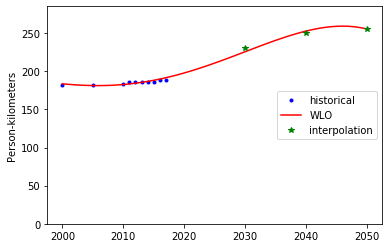

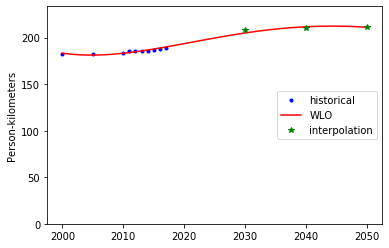

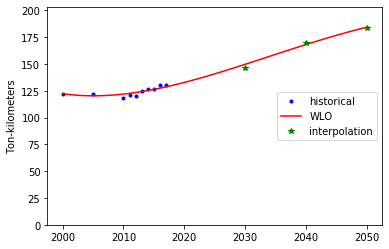

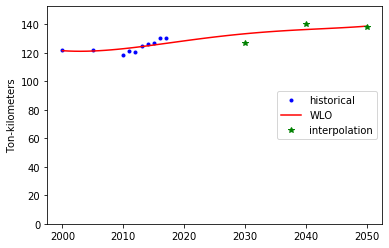

<Figure size 432x288 with 0 Axes>

In [3]:
### set x-axis and fidelity.
startmodel = 2000
endmodel = 2050
x = np.linspace(startmodel, endmodel, endmodel-startmodel+1)

### read data
wloHP = pd.read_csv('data/modalshift/WLOHpassenger.csv', index_col=0,header=0)
wloLP = pd.read_csv('data/modalshift/WLOLpassenger.csv', index_col=0,header=0)
wloHF = pd.read_csv('data/modalshift/WLOHfreight.csv', index_col=0,header=0)
wloLF = pd.read_csv('data/modalshift/WLOLfreight.csv', index_col=0,header=0)

### convert to numeric column
### force polynomials to flatten out at 2050.
wloHP.loc[2040,'Total']=250
wloLP.loc[2040,'Total']=210
wloHF.loc[2040,'Total']=170
wloLF.loc[2040,'Total']=140

### "PolyXX" is the passenger transport service demand over time.
PolyHP = PolyFit(x, wloHP, 'HP')
PolyLP = PolyFit(x, wloLP, 'LP')
PolyHF = PolyFit(x, wloHF, 'HF')
PolyLF = PolyFit(x, wloLF, 'LF')


In [4]:
# dfHP.loc[dfHP['Vehicle']=='ice'].head(20)# df.loc[df['Vehicle']=='bike']
# dfHP.loc[dfHP['VehicleCount']==None]#.unique()
# dfHP

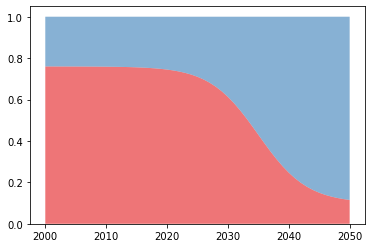

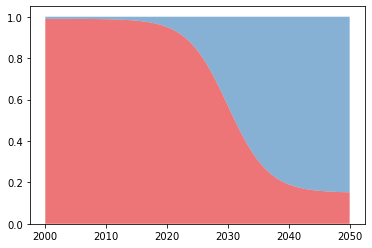

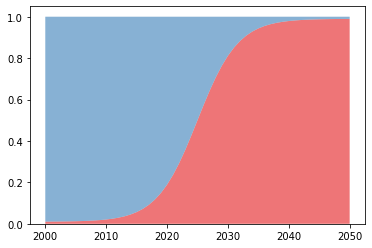

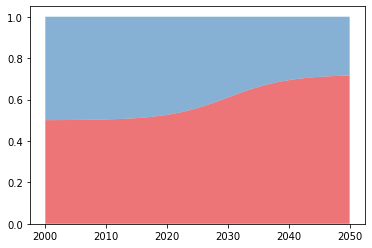

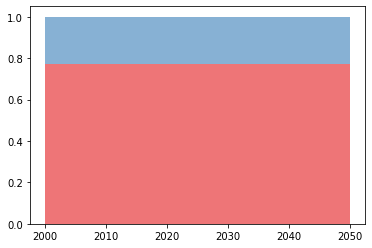

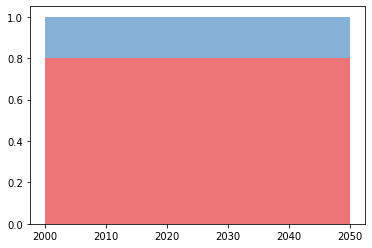

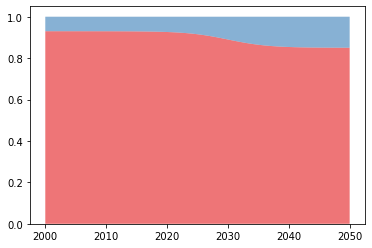

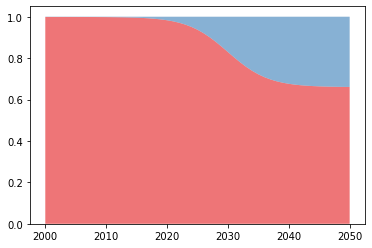

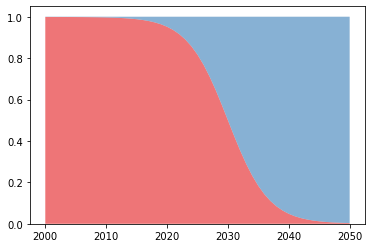

<Figure size 432x288 with 0 Axes>

In [10]:
BinaryShifts(x, DHP, 'HoogPerson', figs=True)



Driving 0.115
Transit 0.634
Cycling 0.201
Walking 0.05


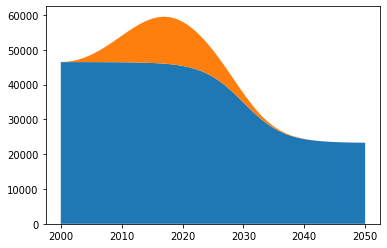

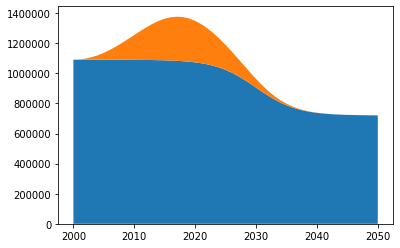

<Figure size 432x288 with 0 Axes>

In [8]:
###    R U N   F U N C T I O N S   P E R S O N   T R A N S P O R T 

### calculates shares per vehicle type
dfHP, DHP = CarsFirst(x, PolyHP)
# BinaryShifts(x, DHP, 'HoogPerson', figs=False)
PlotService(x, dfHP, y='Share', scn='HoogPerson', figs=True)
PlotService(x, dfHP, y='Person-kilometers', scn='HoogPerson', figs=True)

### translates service demand to amount of vehicles needed
dfHP, STVhp = ServiceToPersonVehicles(x, dfHP, figs=True)
# BinaryShifts(x, STVhp, 'StV', figs=True)
PlotService(x, dfHP, y='VehicleCount', scn='HoogPerson', figs=True)


In [6]:
###    R U N   F U N C T I O N S   F R E I G H T   T R A N S P O R T 

### calculates shares per vehicle type
dfHF, DHF = RoadFirst(x, PolyHF)
BinaryShifts(x, DHF, 'Freight', figs=False)
PlotService(x, dfHF, y='Share', scn='HoogFreight', figs=True)
PlotService(x, dfHF, y='Ton-kilometers', scn='HoogFreight', figs=True)

### translates service demand to amount of vehicles needed
dfHF, STVhf = ServiceToFreightVehicles(x, dfHF, figs=True)
# BinaryShifts(x, STVhp, 'StV', figs=True)
PlotService(x, dfHF, y='VehicleCount', scn='HoogPerson', figs=True)



Road 0.305
Rail 0.269
Inland 0.427


<Figure size 432x288 with 0 Axes>